In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print(f"Using {device} device")

Using cpu device


In [3]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
    
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)

## Data Path Setup

In [4]:
data_dir = "C://Users//DELL//Desktop//Computer_Vision_Projects//tubato_plant_dx//data//external//"
train_dir = os.path.join(data_dir, 'train')

print("Will read data from", train_dir)

Will read data from C://Users//DELL//Desktop//Computer_Vision_Projects//tubato_plant_dx//data//external//train


In [5]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['cassava_brown_streak', 'cassava_mosaic_disease', 'healthy', 'potato_early_blight', 'potato_late_blight', 'tomato_early_blight', 'tomato_late_blight']
That's 7 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [6]:
batch_size = 20
dataset_loader = DataLoader(dataset, batch_size=batch_size)

first_batch = next(iter(dataset_loader))
print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels:{first_batch[1].shape}")

Shape of one batch: torch.Size([20, 3, 224, 224])
Shape of labels:torch.Size([20])


## Preparing Data

In [7]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

 Next, run the "get_mean_std" function on the training data to calculate the channel mean & std.

In [8]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Computing mean and std:   0%|          | 0/68 [00:00<?, ?it/s]

Mean: tensor([0.4644, 0.4767, 0.4162])
Standard Deviation: tensor([0.1852, 0.1733, 0.1974])


In [9]:
transform_norm = transforms.Compose(
    [
     ConvertToRGB(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)
    ]
)

Make a new normalized dataset using "ImageFolder" and a new "DataLoader"

In [10]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(dataset=norm_dataset, batch_size=20)

Use the "get_mean_std" function to verify the mean and standard deviation are correct in the "norm_loader" data

In [11]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard Deviation: {norm_std}")

Computing mean and std:   0%|          | 0/68 [00:00<?, ?it/s]

Mean: tensor([-3.1131e-07, -8.0422e-08, -1.3247e-07])
Standard Deviation: tensor([1.0000, 1.0000, 1.0000])


## Train and Validation Splitting

In [12]:
g = torch.Generator()
g.manual_seed(42)

In [13]:
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100*length_train / length_dataset, 2)
percent_val = np.round(100*length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val} of full data")

Train data is 80.04% of full data
Validation data is 19.96 of full data


In [14]:
def class_counts(dataset):
    ds = dataset.dataset if isinstance(dataset, Subset) else dataset
    counts = Counter(lbl for _, lbl in tqdm(dataset, desc="Counting classes"))
    return pd.Series({cls: counts[idx] for cls, idx in ds.class_to_idx.items()})

In [15]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions

Counting classes:   0%|          | 0/1087 [00:00<?, ?it/s]

cassava_brown_streak        8
cassava_mosaic_disease     23
healthy                   313
potato_early_blight       151
potato_late_blight        157
tomato_early_blight       147
tomato_late_blight        288
dtype: int64

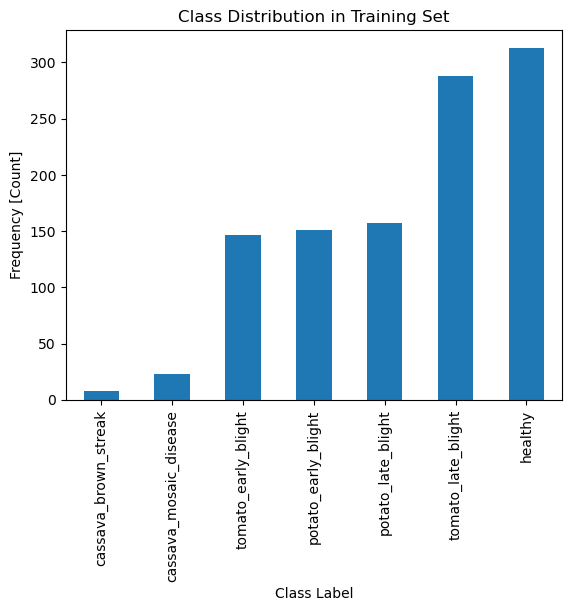

In [16]:
train_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Training Set");

Counting classes:   0%|          | 0/271 [00:00<?, ?it/s]

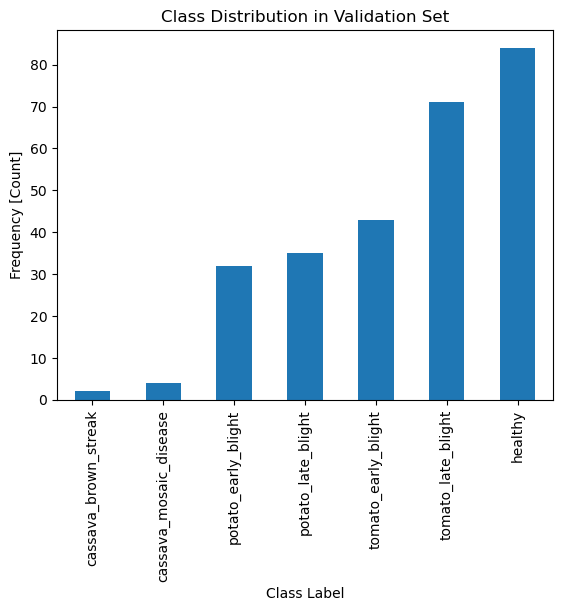

In [17]:
validation_class_distributions = class_counts(val_dataset)

validation_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Validation Set");